In [1]:
import tushare as ts
import pandas as pd
import numpy as np

download the data from sina

In [2]:

df1 = ts.profit_data(2016, top = 1200)
df1.index = df1['code']
df2 = ts.get_stock_basics()

df3 = pd.merge(df1, df2, on='name')
df3.index = df3['code']

[Getting data:]###############################################

show the data

In [4]:
df3.head()

,code,name,year,report_date,divi,shares,industry,area,pe,outstanding,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
002827,002827,高争民爆,2016,2017-04-15,3.0,0.0,化工原料,西藏,49.60,0.46,...,2.68,10.82,20161209,13980.00,0.76,0.00,0.00,53.77,29.85,21963
603669,603669,灵康药业,2016,2017-04-15,1.2,0.0,化学制药,西藏,52.42,0.86,...,4.30,6.34,20150528,16225.12,0.62,-13.35,1.32,56.36,31.52,22035
300560,300560,中富通,2016,2017-04-15,1.0,5.0,通信设备,福建,115.03,0.18,...,5.60,11.33,20161101,17392.32,2.48,0.00,0.00,29.61,11.84,13174
300494,300494,盛天网络,2016,2017-04-15,1.4,0.0,互联网,湖北,70.91,0.86,...,3.61,7.58,20151231,24025.82,1.00,52.43,28.67,56.18,29.33,25449
603568,603568,伟明环保,2016,2017-04-15,2.0,0.0,环境保护,浙江,49.43,1.31,...,2.71,9.08,20150528,91895.25,1.34,0.90,14.22,65.00,50.09,27589


for all the futures I select these 9 futures

shares: high bonus shares per 10 shares

outstanding: the number of outstanding shares

totals: the number of total shares 

bvps: book value per share

reservedPerShare: including capital paid in excess of Par and corporate reserves

perundp: part of the retained earnings 

pb: Price-to-Book ratio

rev: the growth rate of sales

profit: the growth rate of net profit

In [13]:

df = df3[['shares','outstanding','totals', 'reservedPerShare',
         'bvps', 'perundp', 'pb', 'rev', 'profit']]
df.index = df3.index

show the data

In [14]:
df.head()


,shares,outstanding,totals,reservedPerShare,bvps,perundp,pb,rev,profit
code,,,,,,,,,
002827,0.0,0.46,1.84,0.35,2.68,0.76,10.82,0.00,0.00
603669,0.0,0.86,2.60,2.49,4.30,0.62,6.34,-13.35,1.32
300560,5.0,0.18,0.70,0.74,5.60,2.48,11.33,0.00,0.00
300494,0.0,0.86,2.40,1.40,3.61,1.00,7.58,52.43,28.67
603568,0.0,1.31,6.87,0.26,2.71,1.34,9.08,0.90,14.22


define the high bonus as >= 10


In [15]:
bonus=(df['shares']>=10)


add the target into the DataFrame


In [16]:
df.insert(0,'bonus',bonus)
del df['shares']          

visualize the data to get some intuition

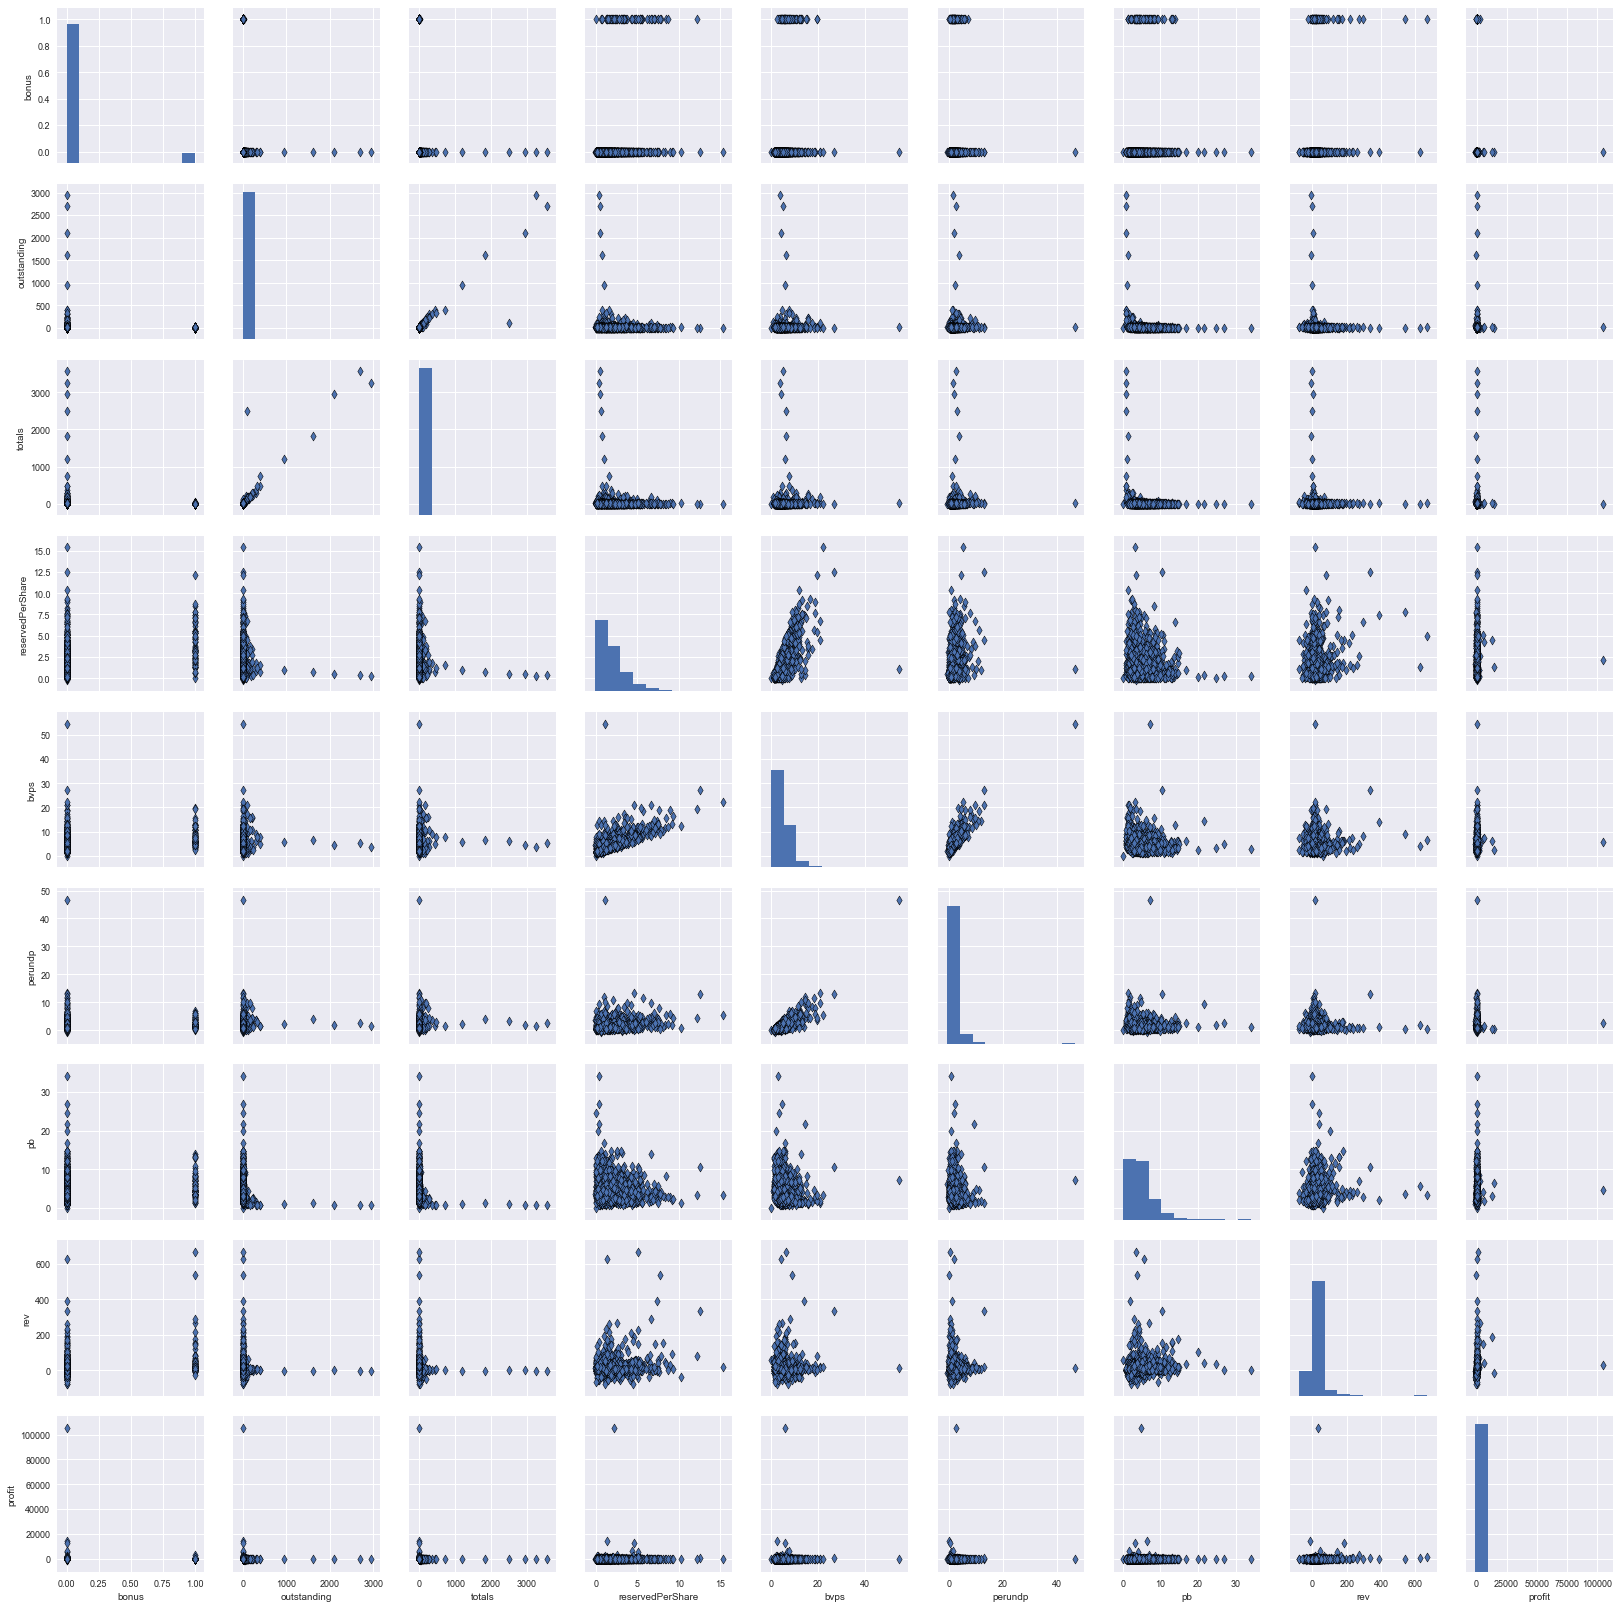

In [21]:

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.pairplot(df, markers='d', size=2.5, plot_kws=
    {"s":40,
    "alpha":1.0,
    'lw':0.5,
    'edgecolor':'k'})
plt.show()

draw the heat map

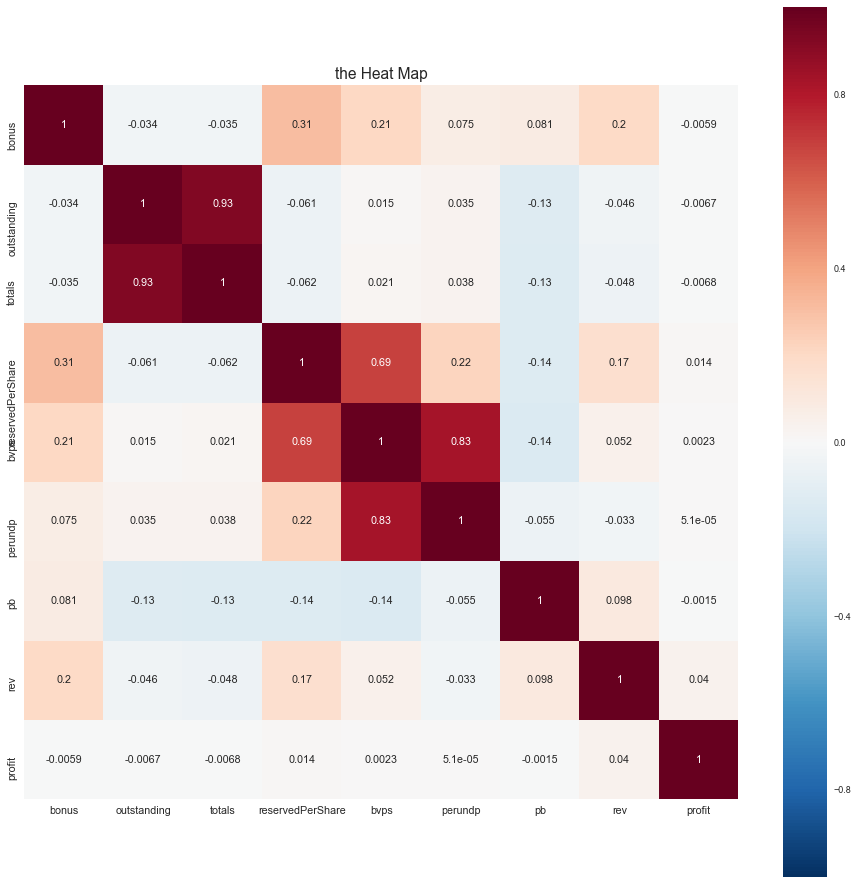

In [22]:
f, axes = plt.subplots(1, 1, figsize=(16, 16), sharex=True)

a=[]
colsre=[]
cols = ['bonus','outstanding','totals', 'reservedPerShare',
         'bvps', 'perundp', 'pb', 'rev', 'profit']

for i in range(8,-1,-1):
    colsre.append(cols[i])

for x in cols:
    s = df[x].values
    a.append(s)
    
cm = np.corrcoef(a)

sns.set(font_scale=0.9)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True)

axes.set_title('the Heat Map',fontsize='x-large')
axes.set_xticklabels(cols, fontsize='medium')
axes.set_yticklabels(colsre, fontsize='medium')
plt.show()

then 'reservedPerShare' and 'bvps' are found to be the most important futures

I first do analysis based on these two futures

In [23]:

from sklearn.model_selection import train_test_split

X = df[['reservedPerShare', 'bvps']]
y = df['bonus']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.4, random_state=0)

from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


I use SVM to analize 

first choose the best parameters of SVC

In [24]:

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

ES = SVC(kernel='rbf', random_state=0, gamma=0.10, C=1.0)
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 0.01, 0.1, 1, 10],
              'gamma':[0.01, 0.1, 1, 10]}

gs = GridSearchCV(ES, parameters)

gs = gs.fit(X_train_std, y_train)

svc_score = gs.best_score_
svc_para = gs.best_params_
print('The accurency of SVC: %f' % svc_score)
print('The chosen parameters of SVC: %s' % svc_para)


The accurency of SVC: 0.931133
The chosen parameters of SVC: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}


then set the parameters of SVC

In [25]:
svc = SVC(kernel='rbf', random_state=0, gamma=10, C=1)

Choose the best parameters of Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3,
                              random_state=0)

parameters = {'criterion':('entropy', 'gini'), 'max_depth':[1,2,3,4,5]}

gs = GridSearchCV(tree, parameters)

gs = gs.fit(X_train, y_train)

TREE_score = gs.best_score_
TREE_para = gs.best_params_
print('The accurency of Decision Tree: %f' % TREE_score)
print('The chosen parameters of Decision Tree: %s' % TREE_para)

The accurency of Decision Tree: 0.929699
The chosen parameters of Decision Tree: {'criterion': 'entropy', 'max_depth': 1}


then set the parameters

In [28]:

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=0)

Choose the best parameters of RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=3, 
                                random_state=0)

parameters = {'criterion':('entropy', 'gini'), 'n_estimators':[1,2,3,4,5]}

gs = GridSearchCV(forest, parameters)

gs = gs.fit(X_train, y_train)

forest_score = gs.best_score_
forest_para = gs.best_params_
print('The accurency of Decision Tree: %f' % forest_score)
print('The chosen parameters of Decision Tree: %s' % forest_para)

The accurency of Decision Tree: 0.911047
The chosen parameters of Decision Tree: {'criterion': 'entropy', 'n_estimators': 4}


then set forest as below

In [30]:
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=4, 
                                random_state=0)

other methods and voteingclass

In [32]:

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=10, 
                        max_samples=10, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=10, 
                         learning_rate=0.5,
                         random_state=0)


vote = VotingClassifier(estimators=[('decision tree', tree), ('bagging', bag), 
                                    ('adaboosting', ada),('forest',forest)],
                        voting='soft',  weights=[1,1,1,1])

for idx, clf, tt in zip([0, 1, 2, 3, 4],
                        [tree, bag, ada, forest, vote],
                        ['Decision Tree','Bagging', 'AdaBoost',
                        'Random Forest', 'Majority Vote']):

        clf.fit(X_train, y_train)
    
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        clf_train = accuracy_score(y_train, y_train_pred)
        clf_test = accuracy_score(y_test, y_test_pred)
    
        print('%s train/test accuracies %.3f/%.3f'% (tt,clf_train, clf_test))


Decision Tree train/test accuracies 0.930/0.940
Bagging train/test accuracies 0.930/0.940
AdaBoost train/test accuracies 0.930/0.940
Random Forest train/test accuracies 0.960/0.918
Majority Vote train/test accuracies 0.930/0.940


the result seems too good

then we obtain the confusion matrix

In [41]:
from sklearn.metrics import confusion_matrix

def CM(output):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(output, cmap=plt.cm.Blues)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            ax.text(x=j, y=i, s=output[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

SVC

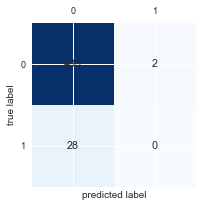

In [42]:

svc.fit(X_train_std,y_train)
y_pred=svc.predict(X_test_std)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)


decision tree

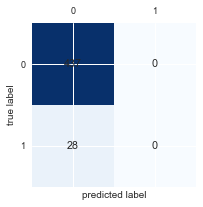

In [43]:

tree.fit(X_train_std,y_train)
y_pred=tree.predict(X_test_std)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)

bagging

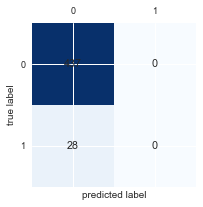

In [44]:

bag.fit(X_train_std,y_train)
y_pred=bag.predict(X_test_std)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)

adaboosting

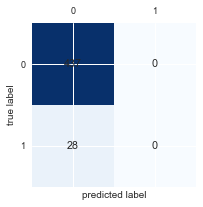

In [45]:

ada.fit(X_train_std,y_train)
y_pred=ada.predict(X_test_std)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)

random forest

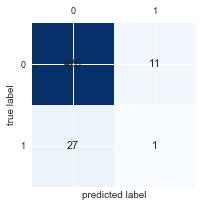

In [46]:

forest.fit(X_train_std,y_train)
y_pred=forest.predict(X_test_std)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)

majority vote

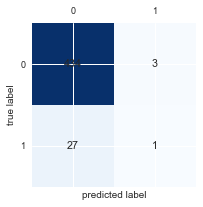

In [47]:
vote.fit(X_train_std,y_train)
y_pred=vote.predict(X_test_std)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)


then I find that the score is not that useful

since I am about to predict the companies that will send high bonus share

I focus on the prediction of 1 

but all these models seems to predict that all companies send no high bonus share 

and since the company that will send high bonus share is less than 10%

the model still get a high score

However, that is not what I want

then I decide to use more information
maybe train via PCA

In [50]:
from sklearn.decomposition import PCA

del df['bonus']

x_train, x_test, y_train, y_test = \
    train_test_split(df, y, test_size=0.4, random_state=0)

from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
x_train_std = stdsc.fit_transform(x_train)
x_test_std = stdsc.transform(x_test)

pca= PCA(n_components=2)

x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

pca.explained_variance_ratio_.sum()

0.51895571529739581

it seems 2 componets of PCA cannot explain the result well

In [51]:

pca= PCA(n_components=5)

x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

pca.explained_variance_ratio_.sum()

0.90037084620497643

I decide to use 5 components

which can explain 90% of the variance

then use the SVC

In [54]:
ES = SVC(kernel='rbf', random_state=0, gamma=0.10, C=1.0)
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 0.01, 0.1, 1, 10],
              'gamma':[0.01, 0.1, 1, 10]}

gs = GridSearchCV(ES, parameters)

gs = gs.fit(x_train_pca, y_train)

svc_score = gs.best_score_
svc_para = gs.best_params_
print('The accurency of SVC: %f' % svc_score)
print('The chosen parameters of SVC: %s' % svc_para)

The accurency of SVC: 0.929699
The chosen parameters of SVC: {'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}


In [56]:

svc = SVC(kernel='linear', random_state=0, gamma=0.01, C=0.001)


other methods

In [57]:

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=5,
                              random_state=0)


bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=10, 
                        max_samples=10, 
                        bootstrap=True, 
                        bootstrap_features=False)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=10, 
                         learning_rate=0.5,
                         random_state=0)

chose the parameters for forest


In [58]:

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=3, 
                                random_state=0)

parameters = {'criterion':('entropy', 'gini'), 'n_estimators':[1,2,3,4,5]}

gs = GridSearchCV(forest, parameters)

gs = gs.fit(x_train_pca, y_train)

forest_score = gs.best_score_
forest_para = gs.best_params_
print('The accurency of Decision Tree: %f' % forest_score)
print('The chosen parameters of Decision Tree: %s' % forest_para)

The accurency of Decision Tree: 0.923960
The chosen parameters of Decision Tree: {'criterion': 'gini', 'n_estimators': 4}


then I set the model as

In [59]:
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=4, 
                                random_state=0)

once more use the majority voting model

In [60]:

vote = VotingClassifier(estimators=[('decision tree', tree), ('bagging', bag), 
                                    ('adaboosting', ada),('forest',forest)],
                        voting='soft',  weights=[1,1,1,1])


In [61]:

for idx, clf, tt in zip([0, 1, 2, 3, 4],
                        [tree, bag, ada, forest, vote],
                        ['Decision Tree','Bagging', 'AdaBoost',
                        'Random Forest', 'Majority Vote']):

        clf.fit(x_train_pca, y_train)
    
        y_train_pred = clf.predict(x_train_pca)
        y_test_pred = clf.predict(x_test_pca)

        clf_train = accuracy_score(y_train, y_train_pred)
        clf_test = accuracy_score(y_test, y_test_pred)
    
        print('%s train/test accuracies %.3f/%.3f'% (tt,clf_train, clf_test))

Decision Tree train/test accuracies 0.950/0.938
Bagging train/test accuracies 0.930/0.940
AdaBoost train/test accuracies 1.000/0.920
Random Forest train/test accuracies 0.964/0.927
Majority Vote train/test accuracies 0.986/0.929


then I check the confusionmmatrix

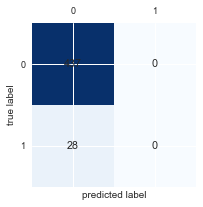

In [62]:

svc.fit(x_train_pca,y_train)
y_pred=svc.predict(x_test_pca)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)
wrong_y = (y_test!=y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)


SVC still not working fine

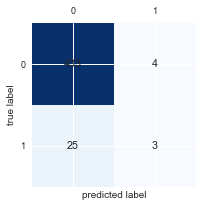

In [63]:

tree.fit(x_train_pca,y_train)
y_pred=tree.predict(x_test_pca)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)
wrong_y = (y_test!=y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)


decision tree seems much better

the accuracy reaches 3/7

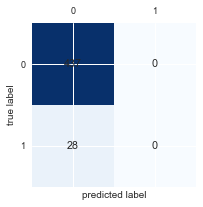

In [65]:

bag.fit(x_train_pca,y_train)
y_pred=bag.predict(x_test_pca)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)
wrong_y = (y_test!=y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)


bagging still not working fine

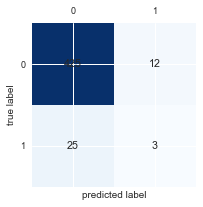

In [66]:

ada.fit(x_train_pca,y_train)
y_pred=ada.predict(x_test_pca)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)
wrong_y = (y_test!=y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)


adaboosting a little bit better

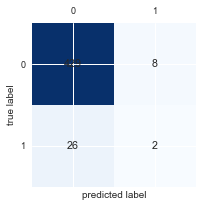

In [67]:

forest.fit(x_train_pca,y_train)
y_pred=forest.predict(x_test_pca)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)
wrong_y = (y_test!=y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)



randomforest a little bit better

then according to the effect reset the votingclassifier

In [73]:
vote = VotingClassifier(estimators=[('decision tree', tree), ('bagging', bag), 
                                    ('adaboosting', ada),('forest',forest)],
                        voting='hard',  weights=[6.5,0.5,2,1])


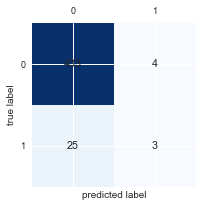

In [74]:

vote.fit(x_train_pca,y_train)
y_pred=vote.predict(x_test_pca)
y_pred = pd.Series(y_pred)
y_test = tuple(y_test)
y_pred = tuple(y_pred)

output = confusion_matrix(y_true=y_test, y_pred=y_pred)
CM(output)


then I get the final model which seems not so good but much better than before 

with 3/7 chance to find the company that will send high bonus share

thus, it is very hard to beat the market